In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [2]:
data = pd.read_csv('Leads.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [3]:
# Let's check the missing values percentage in each column

round(100*data.isna().sum()/len(data),2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   15.56
How did you hear about X Education               23.89
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

In [4]:
# Let's look into the data

data.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


In [5]:
# Remove the columns with more than 40% missing values

missing_values = data.isnull().sum()
missing_values_percentage = missing_values/len(data)
columns_to_drop = missing_values_percentage[missing_values_percentage > 0.4].index.tolist()
data = data.drop(columns_to_drop, axis=1)
data.shape

(9240, 32)

In [6]:
# Drop the "Prospect ID" and "Lead Number" columns as they serve no purpose in building the model

data = data.drop(["Prospect ID", "Lead Number"], axis=1)
data.shape

(9240, 30)

In [7]:
# Drop the columns that have a low number of "Yes", as they won't affect the model performance.

data = data.drop(["Receive More Updates About Our Courses","Magazine", "Search", "Newspaper Article", "X Education Forums", "Newspaper", "Digital Advertisement", "Through Recommendations", "Update me on Supply Chain Content", "Do Not Call", "Get updates on DM Content", "I agree to pay the amount through cheque" ], axis=1)
data.shape

(9240, 18)

In [8]:
# Let's look into the data

data.describe()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9240.000000,9103.000000,9240.000000,9103.000000
mean,0.385390,3.445238,487.698268,2.362820
std,0.486714,4.854853,548.021466,2.161418
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,12.000000,1.000000
50%,0.000000,3.000000,248.000000,2.000000
75%,1.000000,5.000000,936.000000,3.000000
max,1.000000,251.000000,2272.000000,55.000000


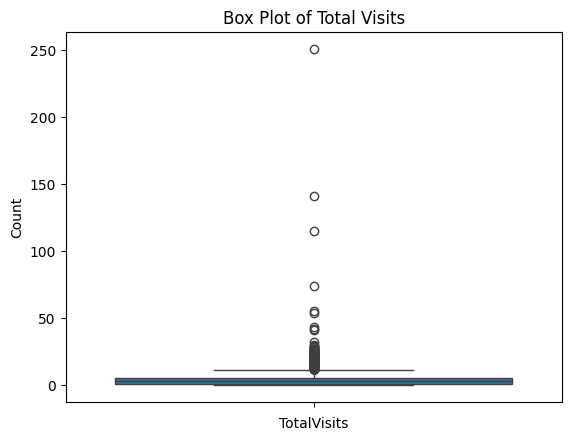

In [9]:
# Let's plot a boxplot for the TotalVisits column

sns.boxplot(data.TotalVisits)
plt.title("Box Plot of Total Visits")
plt.xlabel('TotalVisits')
plt.ylabel('Count')
plt.show()

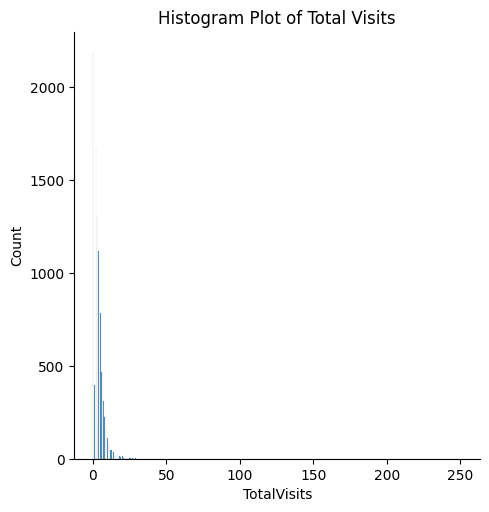

In [10]:
# Plot a histogram for the TotalVisits column

sns.displot(data.TotalVisits)
plt.title('Histogram Plot of Total Visits')
plt.show()

We can see that there are heavy outliers, skewing the data. Hence these outliers are to be removed.

In [11]:
# Remove the rows that have a high number of Total Visits (> 20), as they skew the entire column data

data = data[~(data.TotalVisits>20)]

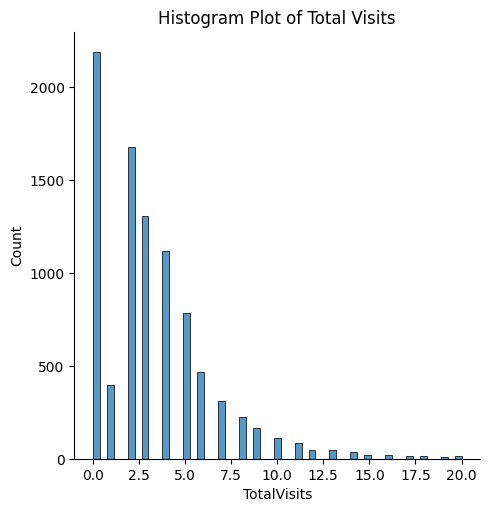

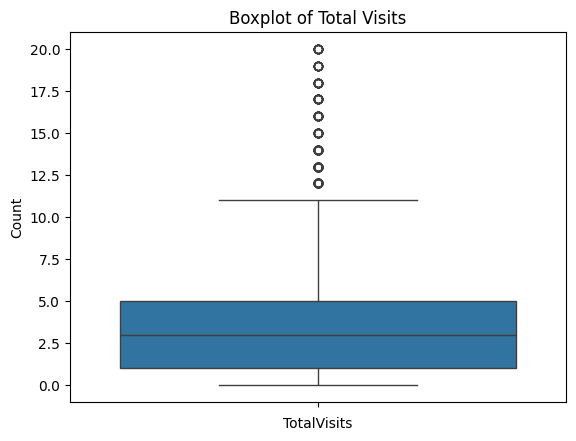

In [12]:
# Let's plot the histogram and boxplot for the TotalVisits column again

sns.displot(data.TotalVisits)
plt.title('Histogram Plot of Total Visits')
plt.show()
sns.boxplot(data.TotalVisits)
plt.title('Boxplot of Total Visits')
plt.xlabel('TotalVisits')
plt.ylabel('Count')
plt.show()

In [13]:
# Let's look into the data description again

data.describe()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9193.000000,9056.000000,9193.000000,9056.000000
mean,0.385184,3.269435,487.005113,2.342778
std,0.486665,3.144111,547.923193,2.063161
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,11.000000,1.000000
50%,0.000000,3.000000,248.000000,2.000000
75%,1.000000,5.000000,935.000000,3.000000
max,1.000000,20.000000,2272.000000,16.000000


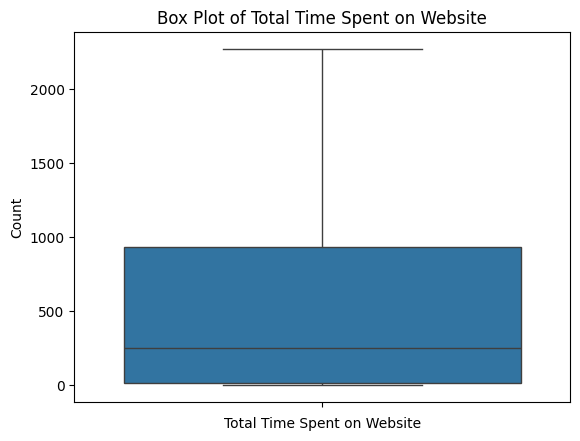

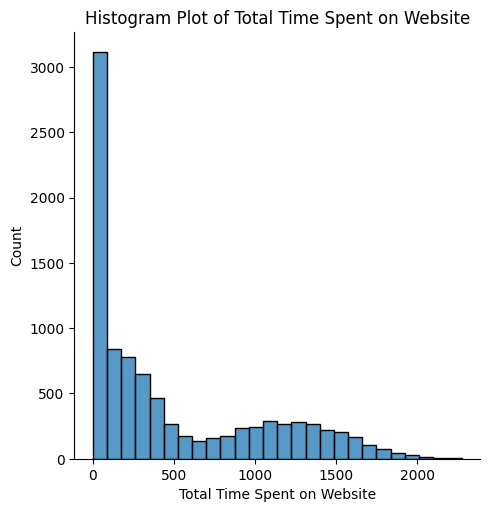

In [14]:
# Let's plot a boxplot and histogram for "Total Time Spent on Website"

sns.boxplot(data["Total Time Spent on Website"])
plt.title("Box Plot of Total Time Spent on Website")
plt.xlabel('Total Time Spent on Website')
plt.ylabel('Count')
plt.show()
sns.displot(data["Total Time Spent on Website"])
plt.title('Histogram Plot of Total Time Spent on Website')
plt.show()

There are no outliers in the "Total Time Spent on Website" column. But the data is heavily skewed towards the left end.

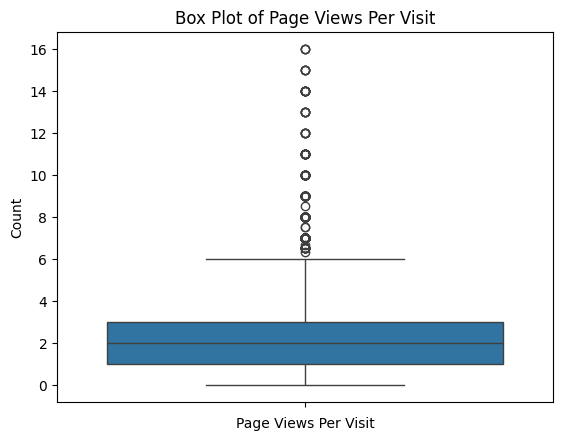

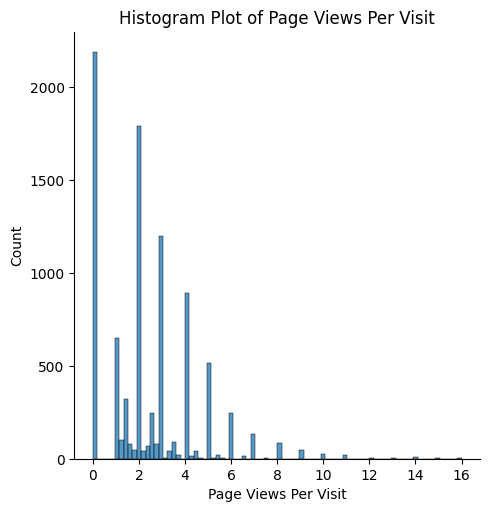

In [15]:
# Let's plot the histogram and boxplot for "Page Views Per Visit" column

sns.boxplot(data["Page Views Per Visit"])
plt.title("Box Plot of Page Views Per Visit")
plt.xlabel('Page Views Per Visit')
plt.ylabel('Count')
plt.show()
sns.displot(data["Page Views Per Visit"])
plt.title('Histogram Plot of Page Views Per Visit')
plt.show()

In [16]:
# Let's remove the outliers from the "Page Views Per Visit" column (> 10 views per visit)

data = data[~(data["Page Views Per Visit"]>10)]

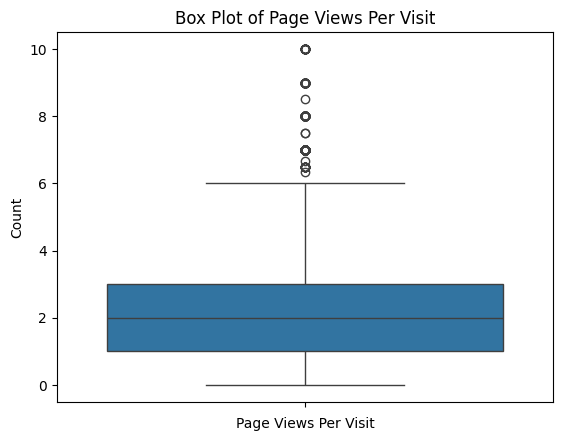

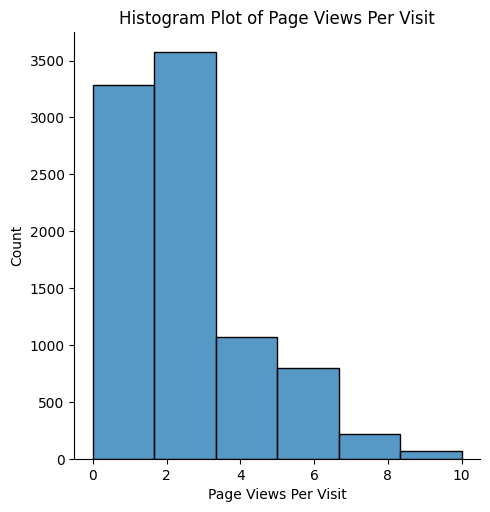

In [17]:
# Let's plot the histogram and boxplot for "Page Views Per Visit" column again

sns.boxplot(data["Page Views Per Visit"])
plt.title("Box Plot of Page Views Per Visit")
plt.xlabel('Page Views Per Visit')
plt.ylabel('Count')
plt.show()
sns.displot(data["Page Views Per Visit"], bins=6)
plt.title('Histogram Plot of Page Views Per Visit')
plt.show()

In [18]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
Specialization                                   15.67
How did you hear about X Education               23.88
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                             36.31
Lead Profile                                     29.33
City                                             15.48
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: flo

In [19]:
# Let's check the "Tags" column

100*data["Tags"].value_counts(normalize=True)

Tags
Will revert after reading the email                  35.284023
Ringing                                              20.353527
Interested in other courses                           8.752360
Already a student                                     7.945770
Closed by Horizzon                                    6.006521
switched off                                          4.084435
Busy                                                  3.174876
Lost to EINS                                          2.968938
Not doing further education                           2.368286
Interested  in full time MBA                          2.007894
Graduation in progress                                1.887764
invalid number                                        1.424404
Diploma holder (Not Eligible)                         1.081174
wrong number given                                    0.789429
opp hangup                                            0.566329
number not provided                               

In [20]:
# Let's impute missing categories as "Others"

data.Tags = data.Tags.fillna("Missing")

In [21]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
Specialization                                   15.67
How did you hear about X Education               23.88
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
Lead Profile                                     29.33
City                                             15.48
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: flo

In [22]:
# Let's check the "Lead Profile" column

100*data["Lead Profile"].value_counts(normalize=True)

Lead Profile
Select                         63.501392
Potential Lead                 24.698423
Other Leads                     7.423446
Student of SomeSchool           3.711723
Lateral Student                 0.355707
Dual Specialization Student     0.309310
Name: proportion, dtype: float64

There are some columns that have the value "Select" in it, which are as good as "Null" values, as they might be the default value for missing data/value that is not filled in while inputting the data. Hence we need to identify these columns and impute the values as Null and check the missing values percentage in each column again.

In [23]:
# Let's check the columns that have the value "Select" in them

columns_with_select = [col for col in data.columns if data[col].isin(['Select']).any()]

columns_with_select

['Specialization',
 'How did you hear about X Education',
 'Lead Profile',
 'City']

In [24]:
# Let's impute the "Select" value with Nulls

data[columns_with_select] = data[columns_with_select].replace('Select', np.nan)

In [25]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
Specialization                                   36.79
How did you hear about X Education               78.47
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
Lead Profile                                     74.20
City                                             39.95
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: flo

In [26]:
# Let's check the City column

100*data["City"].value_counts(normalize=True)

City
Mumbai                         57.844922
Thane & Outskirts              13.396432
Other Cities                   12.413542
Other Cities of Maharashtra     8.227157
Other Metro Cities              6.789225
Tier II Cities                  1.328722
Name: proportion, dtype: float64

In [27]:
# Let's check the City column where the Country is not India, Asia/Pacific, unknowns or nulls

data[~(data["Country"].isin(["India", "Asia/Pacific", np.nan, "unknown"]))]["City"].value_counts(normalize=True)

City
Mumbai                         0.407080
Other Cities                   0.296460
Other Cities of Maharashtra    0.101770
Thane & Outskirts              0.092920
Other Metro Cities             0.088496
Tier II Cities                 0.013274
Name: proportion, dtype: float64

The City column is not aligned with the respective country cities and provided with some random data. Hence we can drop the City column. 

In [28]:
# Let's drop the City column

data = data.drop("City", axis=1)
data.shape

(9149, 17)

In [29]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
Specialization                                   36.79
How did you hear about X Education               78.47
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
Lead Profile                                     74.20
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: float64

In [30]:
# Let's drop the columns "Lead Profile" and "How did you hear about X Education" as they have high number of missing values (> 70%)

data = data.drop(["Lead Profile", "How did you hear about X Education"], axis=1)
data.shape

(9149, 15)

In [31]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
Specialization                                   36.79
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: float64

In [32]:
# Let's check the "Specialization" column

100*data["Specialization"].value_counts(normalize=True)

Specialization
Finance Management                   16.686841
Human Resource Management            14.490749
Marketing Management                 14.352412
Operations Management                 8.663324
Business Administration               6.864949
IT Projects Management                6.259727
Supply Chain Management               5.965762
Banking, Investment And Insurance     5.775549
Media and Advertising                 3.441121
Travel and Tourism                    3.389244
International Business                3.026111
Healthcare Management                 2.697562
Hospitality Management                1.954003
E-COMMERCE                            1.902127
Retail Management                     1.642746
Rural and Agribusiness                1.227736
E-Business                            0.985648
Services Excellence                   0.674390
Name: proportion, dtype: float64

In [33]:
# Let's fill the missing values in the Specialization column with "Missing"

data.Specialization = data.Specialization.fillna("Missing")


In [34]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                          26.90
Specialization                                    0.00
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: float64

In [35]:
# Let's check the 'Country' column

100*data["Country"].value_counts(normalize=True)

Country
India                   95.738636
United States            1.016746
United Arab Emirates     0.792464
Singapore                0.358852
Saudi Arabia             0.313995
United Kingdom           0.224282
Australia                0.194378
Qatar                    0.149522
Hong Kong                0.104665
Bahrain                  0.104665
France                   0.089713
Oman                     0.089713
Germany                  0.059809
unknown                  0.059809
South Africa             0.059809
Nigeria                  0.059809
Kuwait                   0.059809
Canada                   0.059809
Sweden                   0.044856
China                    0.029904
Asia/Pacific Region      0.029904
Uganda                   0.029904
Bangladesh               0.029904
Italy                    0.029904
Belgium                  0.029904
Netherlands              0.029904
Ghana                    0.029904
Philippines              0.029904
Russia                   0.014952
Switze

In [36]:
# We will impute the missing values in the Country column wih "Missing"

data['Country'] = data.Country.fillna('Missing')

In [37]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                           0.00
Specialization                                    0.00
What is your current occupation                  29.13
What matters most to you in choosing a course    29.33
Tags                                              0.00
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: float64

In [38]:
# Let's rename the column "What is your current occupation" to "Occupation"

data.rename(columns={"What is your current occupation": "Occupation"}, inplace=True)

In [39]:
# Let's check the "Occupation" column

100*data["Occupation"].value_counts(normalize=True)

Occupation
Unemployed              85.456508
Working Professional    10.826650
Student                  3.223319
Other                    0.231339
Housewife                0.154226
Businessman              0.107958
Name: proportion, dtype: float64

In [40]:
# Let's impute the missing values of "Occupation" column as "Missing".
data.Occupation = data.Occupation.fillna('Missing')

In [41]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Converted                                         0.00
TotalVisits                                       1.50
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.50
Last Activity                                     1.13
Country                                           0.00
Specialization                                    0.00
Occupation                                        0.00
What matters most to you in choosing a course    29.33
Tags                                              0.00
A free copy of Mastering The Interview            0.00
Last Notable Activity                             0.00
dtype: float64

In [42]:
# Let's look into the "What matters most to you in choosing a course" column

100*data["What matters most to you in choosing a course"].value_counts(normalize=True)

What matters most to you in choosing a course
Better Career Prospects      99.953603
Flexibility & Convenience     0.030931
Other                         0.015466
Name: proportion, dtype: float64

In [43]:
# Since almost all the rows in the column have the same category "Better Career Prospects", let's drop the column "What matters most to you in choosing a course"

data = data.drop("What matters most to you in choosing a course", axis=1)
data.shape

(9149, 14)

In [44]:
# Let's check "Lead Source" column

100*data["Lead Source"].value_counts(normalize=True)

Lead Source
Google               31.252058
Direct Traffic       27.652804
Olark Chat           19.247229
Organic Search       12.246242
Reference             5.848787
Welingak Website      1.558214
Referral Sites        1.294854
Facebook              0.603533
bing                  0.065840
google                0.054867
Click2call            0.043893
Social Media          0.021947
Live Chat             0.021947
youtubechannel        0.010973
Press_Release         0.010973
testone               0.010973
Pay per Click Ads     0.010973
welearnblog_Home      0.010973
WeLearn               0.010973
blog                  0.010973
NC_EDM                0.010973
Name: proportion, dtype: float64

In [45]:
#  We will impute the missing values in the "Lead Source" column with "Missing"

data["Lead Source"] = data["Lead Source"].fillna("Missing")

In [46]:
# Let's check the "Last Activity" column

100*data["Last Activity"].value_counts(normalize=True)

Last Activity
Email Opened                    37.663055
SMS Sent                        30.112757
Olark Chat Conversation         10.700862
Page Visited on Website          6.776476
Converted to Lead                4.731373
Email Bounced                    3.592748
Email Link Clicked               2.929472
Form Submitted on Website        1.271280
Unreachable                      1.005969
Unsubscribed                     0.663277
Had a Phone Conversation         0.331638
Approached upfront               0.099491
View in browser link Clicked     0.055273
Email Received                   0.022109
Email Marked Spam                0.022109
Visited Booth in Tradeshow       0.011055
Resubscribed to emails           0.011055
Name: proportion, dtype: float64

In [47]:
# Let's check the "Last Notable Activity" column

100*data["Last Notable Activity"].value_counts(normalize=True)

Last Notable Activity
Modified                        36.900208
Email Opened                    30.626298
SMS Sent                        23.587277
Page Visited on Website          3.289977
Olark Chat Conversation          1.989288
Email Link Clicked               1.869057
Email Bounced                    0.655809
Unsubscribed                     0.502787
Unreachable                      0.349765
Had a Phone Conversation         0.153022
Email Marked Spam                0.021860
Approached upfront               0.010930
Resubscribed to emails           0.010930
View in browser link Clicked     0.010930
Form Submitted on Website        0.010930
Email Received                   0.010930
Name: proportion, dtype: float64

It seems that the last activity and the last notable activity are the same, except that Last Activity column is having missing categories whereas Last Notable Activity column is completely filled without missing categories. Let's drop the Last Activity column and fill the Last Notable Activity column's missing values with "Missing".

In [48]:
#  Let's drop the Last Activity column

data = data.drop("Last Activity", axis=1)
data.shape

(9149, 13)

In [49]:
# Let's fill the "Last Notable Activity" column missing values with "Missing"

data["Last Notable Activity"] = data["Last Notable Activity"].fillna("Missing")

In [50]:
# Let's check the missing values percentage in each column again

round(100*data.isna().sum()/len(data),2)

Lead Origin                               0.0
Lead Source                               0.0
Do Not Email                              0.0
Converted                                 0.0
TotalVisits                               1.5
Total Time Spent on Website               0.0
Page Views Per Visit                      1.5
Country                                   0.0
Specialization                            0.0
Occupation                                0.0
Tags                                      0.0
A free copy of Mastering The Interview    0.0
Last Notable Activity                     0.0
dtype: float64

In [51]:
# Let's see the data description

data.describe()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9149.000000,9012.000000,9149.000000,9012.000000
mean,0.385179,3.223591,485.813204,2.292410
std,0.486664,3.080153,547.623238,1.934285
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,10.000000,1.000000
50%,0.000000,3.000000,247.000000,2.000000
75%,1.000000,5.000000,932.000000,3.000000
max,1.000000,20.000000,2272.000000,10.000000


In [52]:
# We will impute the columns "TotalVisits" and "Page Views Per Visit" with their mean values

data["TotalVisits"] = data["TotalVisits"].fillna(data["TotalVisits"].mean())
data["Page Views Per Visit"] = data["Page Views Per Visit"].fillna(data["Page Views Per Visit"].mean()) 

In [53]:
# Let's have an overview of the data

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9149 entries, 0 to 9239
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9149 non-null   object 
 1   Lead Source                             9149 non-null   object 
 2   Do Not Email                            9149 non-null   object 
 3   Converted                               9149 non-null   int64  
 4   TotalVisits                             9149 non-null   float64
 5   Total Time Spent on Website             9149 non-null   int64  
 6   Page Views Per Visit                    9149 non-null   float64
 7   Country                                 9149 non-null   object 
 8   Specialization                          9149 non-null   object 
 9   Occupation                              9149 non-null   object 
 10  Tags                                    9149 non-null   object 
 

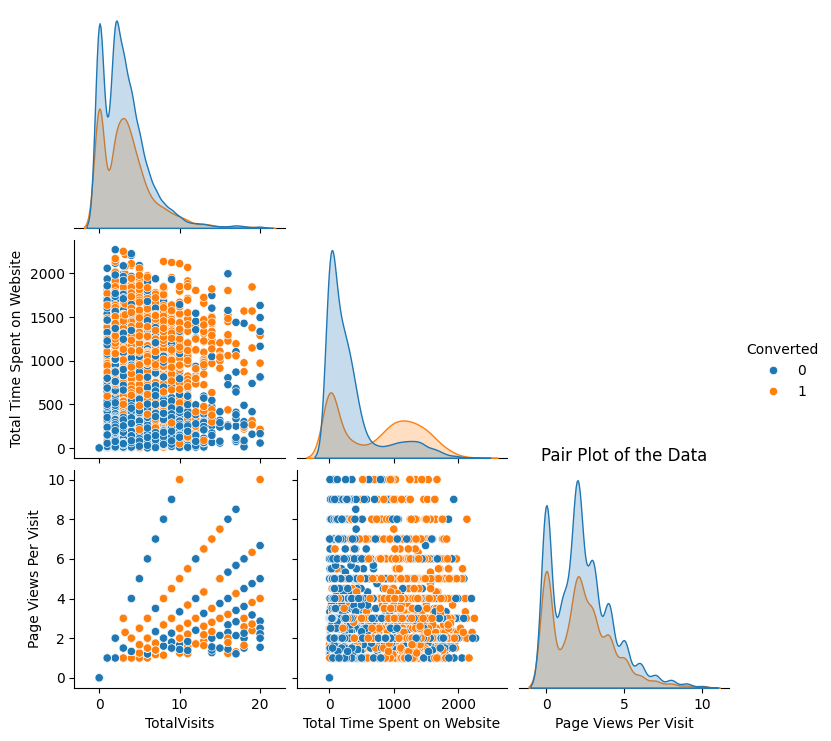

In [54]:
# Let's plot the data for all the columns vs "Converted" column

sns.pairplot(data, hue="Converted", corner=True)
plt.title('Pair Plot of the Data')
plt.show()

Some correlation between Page Views Per Visit and TotalVisits columns exists

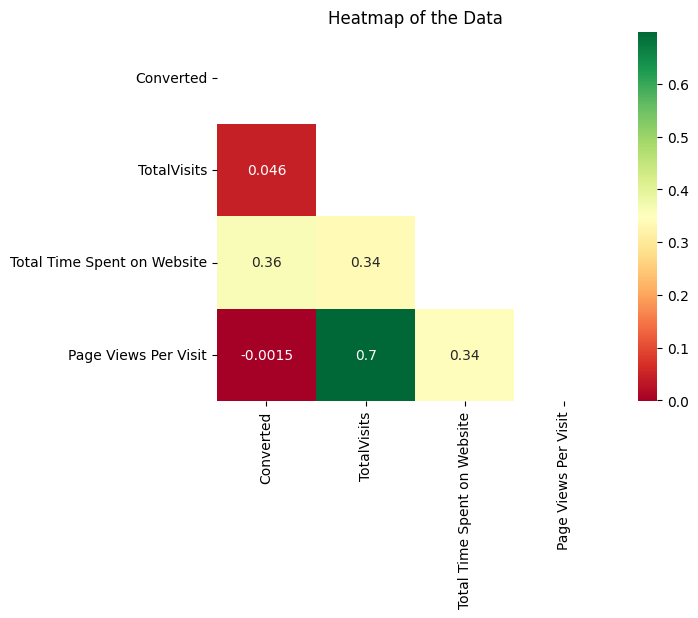

In [55]:
# Let's plot a heatmap of the data
mask = np.triu(np.ones_like(data.corr(numeric_only=True)))
sns.heatmap(data.corr(numeric_only=True), annot=True, mask=mask, cmap='RdYlGn')
plt.title('Heatmap of the Data')
plt.show()

A correlation of 0.7 exists between Page Views Per Visit and TotalVisits columns. Hence we can drop the Page Views Per Visit column

In [56]:
# Let's drop the Page Views Per Visit column

data = data.drop("Page Views Per Visit", axis=1)
data.shape

(9149, 12)

In [57]:
# Let's rename the column "A free copy of Mastering The Interview" to "SampleInterviewCourse"

data.rename(columns={"A free copy of Mastering The Interview": "SampleInterviewCourse"}, inplace=True)

In [58]:
# Let's create dummies for each categorical column

cat_cols = [i for i in data.columns if data[i].dtype =='object']

data = pd.get_dummies(data, columns=cat_cols, drop_first=True, dtype=int)
data.shape

(9149, 133)

In [59]:
# Let's view the data 

data.head()

,Converted,TotalVisits,Total Time Spent on Website,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0,0.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,5.0,674,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2.0,1532,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1.0,305,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,2.0,1428,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [60]:
# Let's split the data into test and training data

X = data.drop("Converted", axis=1)
y = data["Converted"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [61]:
# Let's Normalize the X_train and X_test

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [62]:
# Let's build a Logistic Regression model with all the variables

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [63]:
# Let's predict the output with the model built

y_pred = logreg.predict(X_test)

# Let's check the accuracy

print('Accuracy of logistic regression classifier on test set with all the columns: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Accuracy of logistic regression classifier on test set with all the columns: 0.93


In [64]:
# Let's remove a few columns using Recursive Feature Elimination (RFE)
logreg = LogisticRegression(random_state=42)
selector = RFE(logreg, n_features_to_select=15)
selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.support_]
selected_columns

Index(['Total Time Spent on Website', 'Lead Source_Welingak Website',
       'Occupation_Missing', 'Tags_Busy', 'Tags_Closed by Horizzon',
       'Tags_Lost to EINS', 'Tags_Missing', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_invalid number',
       'Tags_switched off', 'Tags_wrong number given',
       'Last Notable Activity_Olark Chat Conversation',
       'Last Notable Activity_SMS Sent', 'Last Notable Activity_Unsubscribed'],
      dtype='object')

In [65]:
# Let's check the VIF of columns selected from the RFE model with 15 features selected
X_train1 = X_train[selected_columns]
X_test1 = X_test[selected_columns]

def vif(df):
    vif_df = pd.DataFrame()
    vif_df['features'] = df.columns
    vif_df['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_df

vif_df = vif(X_train1)

vif_df

,features,VIF
0,Total Time Spent on Website,1.860694
1,Lead Source_Welingak Website,1.133249
2,Occupation_Missing,4.749516
3,Tags_Busy,1.068622
4,Tags_Closed by Horizzon,1.074556
5,Tags_Lost to EINS,1.083908
6,Tags_Missing,5.313455
7,Tags_Ringing,1.153125
8,Tags_Will revert after reading the email,1.737723
9,Tags_invalid number,1.016492


In [66]:
# Let's check the p-values of the columns we got to see if they are not selected by chance and have a statistical significance

X_train1 = X_train1.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_train_sm = sm.add_constant(X_train1)
logm = sm.Logit(y_train, X_train_sm)
result = logm.fit()
result.summary()

         Current function value: 0.181770
         Iterations: 35


c:\Users\aravi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6404
Model:                          Logit   Df Residuals:                     6388
Method:                           MLE   Df Model:                           15
Date:                Tue, 17 Dec 2024   Pseudo R-squ.:                  0.7277
Time:                        20:12:57   Log-Likelihood:                -1164.1
converged:                      False   LL-Null:                       -4275.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -4.5842      0.212    -21.608      0.000      -5.000      -4.168
Total Time Spent on Website                       3.4834      0.230     15.125      0.000       3.032       3.935
Lead Source_Welingak Website                      3.9335      1.025      3.839      0.000       1.925       5.942
Occupation_Missing                               -2.5396      0.151    -16.808      0.000      -2.836      -2.243
Tags_Busy                                         2.4057      0.302      7.977      0.000       1.815       2.997
Tags_Closed by Horizzon                           9.3758      1.024      9.156      0.000       7.369      11.383
Tags_Lost to EINS                                 8.4805      0.578     14.674      0.000       7.348       9.613
Tags_Missing                                      3.8488      0.232     16.558      0.000       3.393       4.304
Tags_Ringing                                     -1.3229      0.298     -4.443      0.000      -1.906      -0.739
Tags_Will revert after reading the email          6.5366      0.251     26.028      0.000       6.044       7.029
Tags_invalid number                             -18.2159   2790.094     -0.007      0.995   -5486.700    5450.268
Tags_switched off                                -1.8996      0.636     -2.989      0.003      -3.145      -0.654
Tags_wrong number given                         -18.8256   6523.362     -0.003      0.998   -1.28e+04    1.28e+04
Last Notable Activity_Olark Chat Conversation    -1.7663      0.606     -2.914      0.004      -2.954      -0.578
Last Notable Activity_SMS Sent                    2.6920      0.139     19.390      0.000       2.420       2.964
Last Notable Activity_Unsubscribed                0.9023      0.659      1.369      0.171      -0.389       2.194
=================================================================================================================
"""

In [67]:
# From the above statistics, we can see that some of the p-values of the columns are high indicating they are selected by chance
# We will drop the columns that have high p-values one after the other

X_train1 = X_train1.drop("Tags_invalid number", axis=1)
X_test1 = X_test1.drop("Tags_invalid number", axis=1)

In [68]:
# We will check the p-values again now with the updated columns

X_train1 = X_train1.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_train_sm = sm.add_constant(X_train1)
logm = sm.Logit(y_train, X_train_sm)
result = logm.fit()
result.summary()

         Current function value: 0.182719
         Iterations: 35


c:\Users\aravi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6404
Model:                          Logit   Df Residuals:                     6389
Method:                           MLE   Df Model:                           14
Date:                Tue, 17 Dec 2024   Pseudo R-squ.:                  0.7263
Time:                        20:12:57   Log-Likelihood:                -1170.1
converged:                      False   LL-Null:                       -4275.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -4.7490      0.214    -22.222      0.000      -5.168      -4.330
Total Time Spent on Website                       3.4790      0.229     15.159      0.000       3.029       3.929
Lead Source_Welingak Website                      3.9319      1.024      3.838      0.000       1.924       5.940
Occupation_Missing                               -2.5309      0.150    -16.824      0.000      -2.826      -2.236
Tags_Busy                                         2.5977      0.300      8.672      0.000       2.011       3.185
Tags_Closed by Horizzon                           9.5411      1.024      9.314      0.000       7.533      11.549
Tags_Lost to EINS                                 8.6397      0.579     14.932      0.000       7.506       9.774
Tags_Missing                                      4.0222      0.233     17.259      0.000       3.565       4.479
Tags_Ringing                                     -1.1131      0.294     -3.783      0.000      -1.690      -0.536
Tags_Will revert after reading the email          6.7064      0.252     26.596      0.000       6.212       7.201
Tags_switched off                                -1.6872      0.634     -2.663      0.008      -2.929      -0.445
Tags_wrong number given                         -18.7742   7063.693     -0.003      0.998   -1.39e+04    1.38e+04
Last Notable Activity_Olark Chat Conversation    -1.7719      0.606     -2.926      0.003      -2.959      -0.585
Last Notable Activity_SMS Sent                    2.6391      0.136     19.341      0.000       2.372       2.907
Last Notable Activity_Unsubscribed                0.8616      0.653      1.320      0.187      -0.418       2.141
=================================================================================================================
"""

In [69]:
# The column "Tags_wrong number given" has a high p-value. Let's drop that column

X_train1 = X_train1.drop("Tags_wrong number given", axis=1)
X_test1 = X_test1.drop("Tags_wrong number given", axis=1)

In [70]:
# Build the model again with the updated columns

X_train1 = X_train1.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_train_sm = sm.add_constant(X_train1)
logm = sm.Logit(y_train, X_train_sm)
result = logm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.183097
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6404
Model:                          Logit   Df Residuals:                     6390
Method:                           MLE   Df Model:                           13
Date:                Tue, 17 Dec 2024   Pseudo R-squ.:                  0.7257
Time:                        20:12:57   Log-Likelihood:                -1172.6
converged:                       True   LL-Null:                       -4275.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -4.8263      0.214    -22.527      0.000      -5.246      -4.406
Total Time Spent on Website                       3.4831      0.229     15.178      0.000       3.033       3.933
Lead Source_Welingak Website                      3.9323      1.024      3.839      0.000       1.925       5.940
Occupation_Missing                               -2.5283      0.150    -16.830      0.000      -2.823      -2.234
Tags_Busy                                         2.6835      0.298      8.992      0.000       2.099       3.268
Tags_Closed by Horizzon                           9.6181      1.025      9.388      0.000       7.610      11.626
Tags_Lost to EINS                                 8.7143      0.579     15.054      0.000       7.580       9.849
Tags_Missing                                      4.1017      0.233     17.603      0.000       3.645       4.558
Tags_Ringing                                     -1.0209      0.292     -3.491      0.000      -1.594      -0.448
Tags_Will revert after reading the email          6.7847      0.252     26.886      0.000       6.290       7.279
Tags_switched off                                -1.5936      0.633     -2.519      0.012      -2.834      -0.353
Last Notable Activity_Olark Chat Conversation    -1.7747      0.606     -2.929      0.003      -2.962      -0.587
Last Notable Activity_SMS Sent                    2.6190      0.136     19.319      0.000       2.353       2.885
Last Notable Activity_Unsubscribed                0.8688      0.654      1.328      0.184      -0.414       2.151
=================================================================================================================
"""

In [71]:
# Column "Last Notable Activity_Unsubscribed" has a high p-value and hence we will remove it

X_train1 = X_train1.drop("Last Notable Activity_Unsubscribed", axis=1)
X_test1 = X_test1.drop("Last Notable Activity_Unsubscribed", axis=1)

In [72]:
#  Continue building a model without it

X_train1 = X_train1.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_train_sm = sm.add_constant(X_train1)
logm = sm.Logit(y_train, X_train_sm)
result = logm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.183220
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6404
Model:                          Logit   Df Residuals:                     6391
Method:                           MLE   Df Model:                           12
Date:                Tue, 17 Dec 2024   Pseudo R-squ.:                  0.7255
Time:                        20:12:57   Log-Likelihood:                -1173.3
converged:                       True   LL-Null:                       -4275.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -4.8141      0.214    -22.512      0.000      -5.233      -4.395
Total Time Spent on Website                       3.4798      0.229     15.173      0.000       3.030       3.929
Lead Source_Welingak Website                      3.9286      1.024      3.836      0.000       1.921       5.936
Occupation_Missing                               -2.5233      0.150    -16.823      0.000      -2.817      -2.229
Tags_Busy                                         2.6826      0.299      8.984      0.000       2.097       3.268
Tags_Closed by Horizzon                           9.6063      1.024      9.377      0.000       7.598      11.614
Tags_Lost to EINS                                 8.6990      0.578     15.037      0.000       7.565       9.833
Tags_Missing                                      4.0944      0.233     17.589      0.000       3.638       4.551
Tags_Ringing                                     -1.0227      0.292     -3.497      0.000      -1.596      -0.450
Tags_Will revert after reading the email          6.7799      0.252     26.882      0.000       6.286       7.274
Tags_switched off                                -1.5963      0.633     -2.523      0.012      -2.836      -0.356
Last Notable Activity_Olark Chat Conversation    -1.7803      0.606     -2.940      0.003      -2.967      -0.593
Last Notable Activity_SMS Sent                    2.6101      0.135     19.298      0.000       2.345       2.875
=================================================================================================================
"""

In [73]:
# VIF values of the data

vif_df = vif(X_train1)
vif_df

,features,VIF
0,Total Time Spent on Website,1.850320
1,Lead Source_Welingak Website,1.133244
2,Occupation_Missing,4.747639
3,Tags_Busy,1.067156
4,Tags_Closed by Horizzon,1.074234
5,Tags_Lost to EINS,1.083535
6,Tags_Missing,5.302395
7,Tags_Ringing,1.147854
8,Tags_Will revert after reading the email,1.723822
9,Tags_switched off,1.030664


In [74]:
# "Tags_Missing" has a high VIF (>5). Let's drop it

X_train1 = X_train1.drop("Tags_Missing", axis=1)
X_test1 = X_test1.drop("Tags_Missing", axis=1)

In [75]:
# Build the model with the updated columns

X_train1 = X_train1.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_train_sm = sm.add_constant(X_train1)
logm = sm.Logit(y_train, X_train_sm)
result = logm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.220471
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6404
Model:                          Logit   Df Residuals:                     6392
Method:                           MLE   Df Model:                           11
Date:                Tue, 17 Dec 2024   Pseudo R-squ.:                  0.6697
Time:                        20:12:58   Log-Likelihood:                -1411.9
converged:                       True   LL-Null:                       -4275.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -2.6872      0.099    -27.259      0.000      -2.880      -2.494
Total Time Spent on Website                       3.2445      0.203     15.948      0.000       2.846       3.643
Lead Source_Welingak Website                      5.8587      1.022      5.733      0.000       3.856       7.862
Occupation_Missing                               -0.5893      0.115     -5.130      0.000      -0.814      -0.364
Tags_Busy                                         0.5171      0.245      2.109      0.035       0.037       0.998
Tags_Closed by Horizzon                           7.4946      1.007      7.441      0.000       5.521       9.469
Tags_Lost to EINS                                 5.5268      0.517     10.683      0.000       4.513       6.541
Tags_Ringing                                     -3.2508      0.235    -13.850      0.000      -3.711      -2.791
Tags_Will revert after reading the email          4.6676      0.173     27.029      0.000       4.329       5.006
Tags_switched off                                -3.8532      0.607     -6.346      0.000      -5.043      -2.663
Last Notable Activity_Olark Chat Conversation    -1.1518      0.585     -1.968      0.049      -2.299      -0.005
Last Notable Activity_SMS Sent                    2.8314      0.121     23.441      0.000       2.595       3.068
=================================================================================================================
"""

In [76]:
# VIF of the data

vif_df = vif(X_train1)
vif_df

,features,VIF
0,Total Time Spent on Website,1.747241
1,Lead Source_Welingak Website,1.034192
2,Occupation_Missing,1.149235
3,Tags_Busy,1.059353
4,Tags_Closed by Horizzon,1.066023
5,Tags_Lost to EINS,1.039711
6,Tags_Ringing,1.130529
7,Tags_Will revert after reading the email,1.635470
8,Tags_switched off,1.027208
9,Last Notable Activity_Olark Chat Conversation,1.027127


In [77]:
# Let's predict the output with this model
X_train1_pred = sm.add_constant(X_train1)
y_pred = result.predict(X_train1_pred)

In [78]:
# Let's predict the output for test data and append the probabilities to the test data
X_test1_pred = sm.add_constant(X_test1)
y_pred_test = result.predict(X_test1_pred)

##### The probabilities for each lead are to be combined to the train and test data

In [79]:
# We will add the percentage of probabilities (Lead Score) to the train and test data 

X_train1['Lead Score'] = y_pred*100
X_test1['Lead Score'] = y_pred_test*100
X_train1.head()

,Total Time Spent on Website,Lead Source_Welingak Website,Occupation_Missing,Tags_Busy,Tags_Closed by Horizzon,Tags_Lost to EINS,Tags_Ringing,Tags_Will revert after reading the email,Tags_switched off,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_SMS Sent,Lead Score
0,0.739437,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.822572
1,0.814701,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,38.620026
2,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.638505
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,87.871845
4,0.093310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.436539


In [80]:
# See the test data after adding the Lead Score

X_test1.head()

,Total Time Spent on Website,Lead Source_Welingak Website,Occupation_Missing,Tags_Busy,Tags_Closed by Horizzon,Tags_Lost to EINS,Tags_Ringing,Tags_Will revert after reading the email,Tags_switched off,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_SMS Sent,Lead Score
0,0.014525,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.807391
1,0.877201,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.401843
2,0.150968,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,92.202379
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,87.871845
4,0.219630,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,56.646439


In [81]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = np.arange(0,1.01, 0.01)
for i in num:
    y_pred_temp = (y_pred>i).astype(int)
    cm1 = confusion_matrix(y_train, y_pred_temp)
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] = [i ,accuracy,sensi,speci]
cutoff_df.head()

,prob,accuracy,sensi,speci
0.00,0.00,0.387414,1.000000,0.000000
0.01,0.01,0.474703,0.996372,0.144787
0.02,0.02,0.494379,0.995163,0.177670
0.03,0.03,0.505621,0.994760,0.196278
0.04,0.04,0.603217,0.986699,0.360693


Optimal Probability Threshold:  0.25


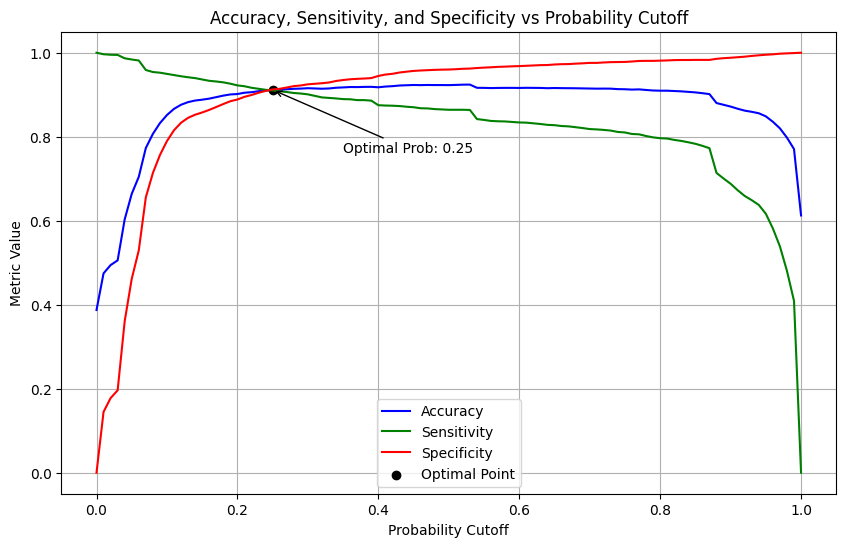

In [82]:
# Plotting the accuracy, sensitivity and specificity for various probabilities

# Calculate the range (max - min) for each row
cutoff_df['metric_range'] = cutoff_df[['accuracy', 'sensi', 'speci']].max(axis=1) - cutoff_df[['accuracy', 'sensi', 'speci']].min(axis=1)

# Select the row with the smallest metric range
optimal_prob = cutoff_df.loc[cutoff_df['metric_range'].idxmin()]

print("Optimal Probability Threshold: ", optimal_prob.prob)

# Plotting only the optimal point
plt.figure(figsize=(10, 6))
plt.plot(cutoff_df['prob'], cutoff_df['accuracy'], label='Accuracy', color='blue')
plt.plot(cutoff_df['prob'], cutoff_df['sensi'], label='Sensitivity', color='green')
plt.plot(cutoff_df['prob'], cutoff_df['speci'], label='Specificity', color='red')
optimal_x = optimal_prob['prob']
optimal_y = optimal_prob['accuracy']
# Mark the optimal point
plt.scatter(optimal_x, optimal_y, color='black', label='Optimal Point')
plt.annotate(
    f'Optimal Prob: {optimal_x:.2f}',  # Annotation text
    xy=(optimal_x, optimal_y),                 # Coordinates to point to
    xytext=(optimal_x + 0.1, optimal_y -0.15),  # Text offset position
    arrowprops=dict(facecolor='black', arrowstyle='->'),  # Arrow style
    fontsize=10, color='black'
)
plt.xlabel('Probability Cutoff')
plt.ylabel('Metric Value')
plt.title('Accuracy, Sensitivity, and Specificity vs Probability Cutoff')
plt.legend()
plt.grid()
plt.show()


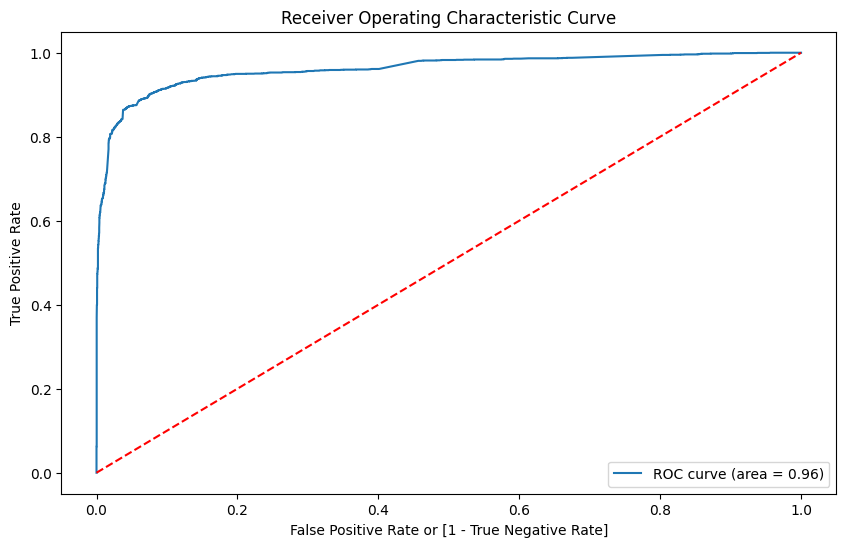

In [83]:
# Use the ROC Curve to find out the model's performance

from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_train, y_pred, drop_intermediate = False)
auc_score = roc_auc_score(y_train, y_pred)
plt.figure(figsize=(10, 6))
plt.plot( fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', color = 'red')
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

From the ROC Curve, we can see that the model is very efficient with an Area under the curve of 0.96.

In [84]:
# Let's assign classes to the train data based on the probability threshold achieved from the accuracy, specifivity and sensitivity curve 

y_pred_label_train = (y_pred >= optimal_prob.prob).astype(int) # Optimal Probability Threshold = 0.25

In [85]:
# Let's do the model evaluation on the train data
print('Model Evaluation on training data')
print(f'Accuracy: {round(accuracy_score(y_train,y_pred_label_train),2)}')

print(f'Precision: {round(precision_score(y_train, y_pred_label_train),2)}')

print(f'Recall: {round(recall_score(y_train, y_pred_label_train),2)}')

print(f'F1 Score: {round(f1_score(y_train, y_pred_label_train),2)}')

Model Evaluation on training data
Accuracy: 0.91
Precision: 0.87
Recall: 0.91
F1 Score: 0.89


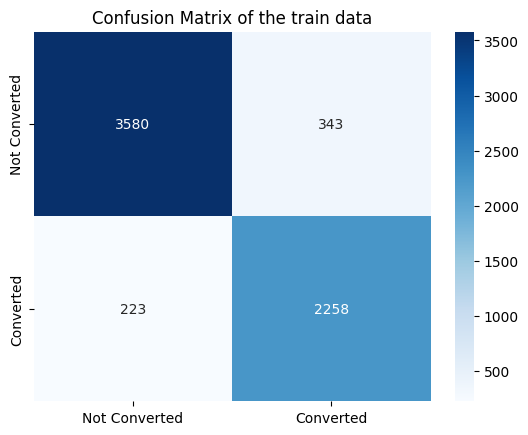

Specificity for training data: 0.91
Sensitivity for training data: 0.91


In [86]:
# Let's get the confusion matrix and Specificity and Sensitivity values for the train data

cm_train = sklearn.metrics.confusion_matrix(y_train, y_pred_label_train)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.title('Confusion Matrix of the train data')
plt.show()

specificity_train = cm_train[0,0]/(cm_train[0,0]+cm_train[0,1])
sensitivity_train = cm_train[1,1]/(cm_train[1,0]+cm_train[1,1])

print(f'Specificity for training data: {round(specificity_train,2)}')

print(f'Sensitivity for training data: {round(sensitivity_train,2)}')

In [90]:
# Let's assign classes to the test data based on the probability threshold achieved from the accuracy, specifivity and sensitivity curve 

y_pred_label_test = (y_pred_test >= optimal_prob.prob).astype(int) # Optimal Probability Threshold = 0.25

In [88]:
# Let's do the model evaluation on the test data
print('Model Evaluation on test data')
print(f'Accuracy: {round(accuracy_score(y_test,y_pred_label_test),2)}')

print(f'Precision: {round(precision_score(y_test,y_pred_label_test),2)}')

print(f'Recall: {round(recall_score(y_test,y_pred_label_test),2)}')

print(f'F1 Score: {round(f1_score(y_test,y_pred_label_test),2)}')

Model Evaluation on test data
Accuracy: 0.9
Precision: 0.86
Recall: 0.9
F1 Score: 0.88


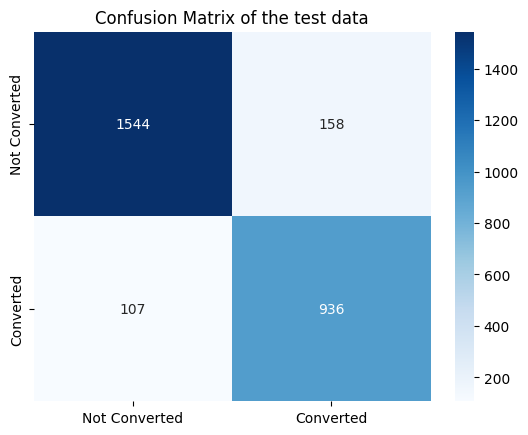

Specificity for test data: 0.91
Sensitivity for test data: 0.9


In [89]:
# Let's get the confusion matrix and Specificity and Sensitivity values for the test data

cm_test = sklearn.metrics.confusion_matrix(y_test, y_pred_label_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.title('Confusion Matrix of the test data')
plt.show()

specificity_test = cm_test[0,0]/(cm_test[0,0]+cm_test[0,1])
sensitivity_test = cm_test[1,1]/(cm_test[1,0]+cm_test[1,1])

print(f'Specificity for test data: {round(specificity_test,2)}')

print(f'Sensitivity for test data: {round(sensitivity_test,2)}')

### <span style="color:cyan">Conclusion</span>

- <span style="color:green">This model performs well on both the training and test data. The accuracy, precision, recall, and F1 scores are all high, indicating a good model.</span>
- <span style="color:green">The sensitivity and specificity for both the training and test data are also high, indicating that the model is able to correctly classify the converted and not converted leads.</span>
- <span style="color:green">The ROC curve and AUC score are also high, indicating that the model is very efficient. Overall, this model is good for predicting lead conversion.</span>